# Data exploration

*This notebook is based on the content of the book "Hands-On Machine Learning with Scikit-Learn,
Keras & TensorFlow"*

Goal:
We want to predict the house prices in california based on different properties.
We use the California housing prices data set.


First we need to download the dataset and load it with pandas.

In [1]:
import os
import tarfile
import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()
housing = pd.read_csv(HOUSING_PATH + "/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can see that there are 10 different attributes. One of them (ocean_proximity) is a categorial variable.

We can use pandas to further describe the data.

In [2]:
housing.info()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


For total_bedrooms we only have 20433 entries instead of the 20640 for the other variables.

Plotting the data shows us that the data really resembles California and that
the housing prices increase closer to the ocean.

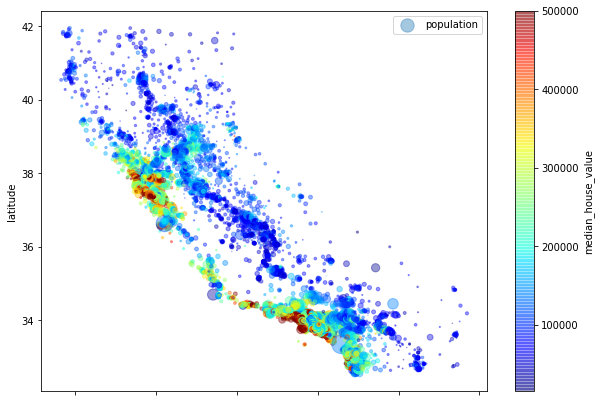

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

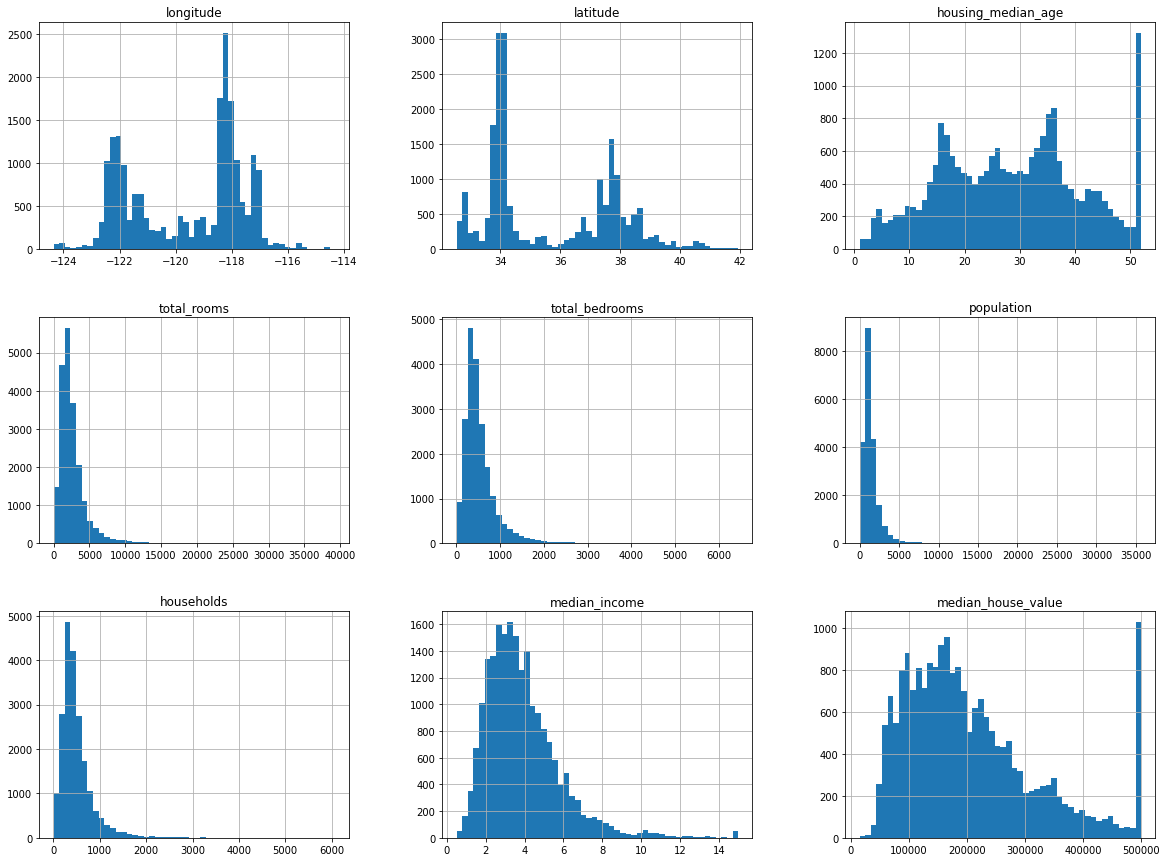

In [4]:
housing.hist(bins=50, figsize=(20,15))

In [5]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

The correlation matrix shows us that the median income is positive correlated with the
price of the house. That makes sense because people with more money would buy more expensive
houses. 
But the number of rooms and the total number of bedrooms has almost no correlation with the price
but logically it should have because more rooms means higher prices. But because the number of rooms is
the added number of all households in that region we need to modify the data to get the average amount
of rooms in the area.

In [6]:
housing_modified = housing.copy()
housing_modified["rooms_per_house"] = housing_modified["total_rooms"]/housing_modified["households"]
housing_modified["bedroom_room_ratio"] = housing_modified["total_bedrooms"]/housing_modified["total_rooms"]
corr_matrix = housing_modified.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedroom_room_ratio   -0.255880
Name: median_house_value, dtype: float64

Now the rooms per house are more positivly correlated and the bedroom/room ratio is interestingly negatively correlated.
That means houses with less bedrooms than other rooms are more expensive.

# Splitting the data

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

train_y = train_set["median_house_value"].copy()
train_x = train_set.drop("median_house_value", axis=1)

test_y = test_set["median_house_value"].copy()
test_x = test_set.drop("median_house_value", axis=1)

# Data cleanup

We need to clean up the data. 
That means we need to
1. fill the missing values
2. rescale the data
3. recalculate the ocean proximity to a one hot vector
4. add the attributes "bedroom_room_ratio", "rooms_per_house"

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_attribs = list(train_x.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

pipeline = ColumnTransformer([
    ("num", Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ]), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
train_x_cleaned = pd.DataFrame(pipeline.fit_transform(train_x))
train_x_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.272587,-1.372811,0.348490,0.222569,0.211228,0.768276,0.322906,-0.326196,-0.174916,0.051376,-0.211785,0.0,0.0,0.0,0.0,1.0
1,0.709162,-0.876696,1.618118,0.340293,0.593094,-0.098901,0.672027,-0.035843,-0.402835,-0.117362,0.342185,0.0,0.0,0.0,0.0,1.0
2,-0.447603,-0.460146,-1.952710,-0.342597,-0.495226,-0.449818,-0.430461,0.144701,0.088216,-0.032280,-0.661658,0.0,0.0,0.0,0.0,1.0
3,1.232698,-1.382172,0.586545,-0.561490,-0.409306,-0.007434,-0.380587,-1.017864,-0.600015,0.077507,0.783032,0.0,0.0,0.0,0.0,1.0
4,-0.108551,0.532084,1.142008,-0.119565,-0.256559,-0.485877,-0.314962,-0.171488,0.349007,-0.068832,-0.550364,0.0,1.0,0.0,0.0,0.0


# Train a linear regression model


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

small_test_x = train_x_cleaned.iloc[:5]
small_test_y = train_y.iloc[:5]

def compute_mse(model):
    predictions = model.predict(small_test_x)
    mse = mean_squared_error(small_test_y, predictions)
    return np.sqrt(mse)

def display_scores(score, cross_val_scores):
    print(f"score: {score}")
    print(f"cross val mean: {cross_val_scores.mean()}")
    print(f"cross val std: {cross_val_scores.std()}")

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_x_cleaned, train_y)
score = compute_mse(lin_reg)

scores = cross_val_score(lin_reg, train_x_cleaned, train_y, scoring="neg_mean_squared_error", cv=10)

display_scores(score, np.sqrt(-scores))

score: 73605.47230869909
cross val mean: 67828.38677377408
cross val std: 2468.091395065229


# Train a regression tree

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_x_cleaned, train_y)
score = compute_mse(tree_reg)

scores = cross_val_score(tree_reg, train_x_cleaned, train_y,
                         scoring="neg_mean_squared_error", cv=10)
display_scores(score, np.sqrt(-scores))

score: 0.0
cross val mean: 68509.62240779566
cross val std: 2215.494218848643


Seems like the regression tree completely overfitted the data because if we use the complete
training set we get a MSE score of zero. If we use cross validation the mean score is worse than
for the linear regressor, this means that also there the tree overfits the data and then
fails on the validation set.

# Train a random forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

random_reg = RandomForestRegressor()
random_reg.fit(train_x_cleaned, train_y)
score = compute_mse(random_reg)

scores = cross_val_score(random_reg, train_x_cleaned, train_y,
                         scoring="neg_mean_squared_error", cv=10)

display_scores(score, np.sqrt(-scores))

score: 12001.448161981956
cross val mean: 49800.63748562473
cross val std: 1815.526998992779


The random forest scores better than the regression tree but also still overfits the data
this can be seen in the difference between the score of the complete train set and the
cross validation set.

# Grid search for best hyperparameters

We try to find the best combination of hyperparameters for our random forest regressor

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 60, 100, 150, 200, 250, 300], 'max_features': [2, 4, 6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 60, 100, 150, 200, 250, 300], 'max_features': [2, 4, 6, 8, 10]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(train_x_cleaned, train_y)
print(f"Best parameters are {grid_search.best_params_}")

KeyboardInterrupt: 

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
forest_mse = compute_mse(grid_search.best_estimator_)
print(f"MSE of best estimator {forest_mse}")

Sees like the best parameter set does overfit the dataset.

We can try the parameters from the book and see that we get a slightly better
result.

In [ ]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg_book = RandomForestRegressor()
grid_search_book = GridSearchCV(forest_reg_book, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_book.fit(train_x_cleaned, train_y)
print(f"Best parameters are {grid_search_book.best_params_}")
forest_book_mse = compute_mse(grid_search_book.best_estimator_)
print(f"MSE book forest {forest_book_mse}")

# Importance of the attributes

Let's plot which attributes are more important to the model

In [ ]:
def show_feature_importances(model):
    extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
    cat_encoder = pipeline.named_transformers_["cat"]
    cat_one_hot_attribs = list(cat_encoder.categories_[0])
    attributes = num_attribs + extra_attribs + cat_one_hot_attribs
    feature_importances = model.feature_importances_
    return sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
show_feature_importances(grid_search_book.best_estimator_)

Much of the attributes seem not very important, especially the ocean proximities that are not "<1H OCEAN" so maybe
we should drop them and retrain the model.

In [19]:
train_x_cleaned.columns = attributes

train_x_dropped_proximity = train_x_cleaned.drop(['INLAND','ISLAND', 'NEAR BAY', 'NEAR OCEAN'], axis=1)
train_x_dropped_proximity.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_hhold,pop_per_hhold,bedrooms_per_room,<1H OCEAN
0,1.272587,-1.372811,0.348490,0.222569,0.211228,0.768276,0.322906,-0.326196,-0.174916,0.051376,-0.211785,0.0
1,0.709162,-0.876696,1.618118,0.340293,0.593094,-0.098901,0.672027,-0.035843,-0.402835,-0.117362,0.342185,0.0
2,-0.447603,-0.460146,-1.952710,-0.342597,-0.495226,-0.449818,-0.430461,0.144701,0.088216,-0.032280,-0.661658,0.0
3,1.232698,-1.382172,0.586545,-0.561490,-0.409306,-0.007434,-0.380587,-1.017864,-0.600015,0.077507,0.783032,0.0
4,-0.108551,0.532084,1.142008,-0.119565,-0.256559,-0.485877,-0.314962,-0.171488,0.349007,-0.068832,-0.550364,0.0


<br>
Lets train a model with our reduced data set.
First we train our model with the parameter sets from the book.
<br><br>


In [ ]:
model_without_prox_book = GridSearchCV(RandomForestRegressor(), param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
model_without_prox_book.fit(train_x_dropped_proximity, train_y)
print(f"Best parameters for book parameters are {model_without_prox_book.best_params_}")

In [ ]:
small_test_set_without_prox = train_x_dropped_proximity.iloc[:5]
small_test_set_without_prox_y = train_y.iloc[:5]

predictions = model_without_prox_book.best_estimator_.predict(small_test_set_without_prox)
wihout_prox_mse = mean_squared_error(small_test_set_without_prox_y, predictions)

print(f"MSE without prox. {np.sqrt(wihout_prox_mse)}; the old MSE from the book {forest_book_mse}")

In [17]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [16]:
feature_importances = model_without_prox_book.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

NameError: name 'model_without_prox_book' is not defined

<br><br>
Now lets try a more drastic approach and crank the parameters a little bit up.
Most likely this will overfit the dataset completly.
<br><br>

In [ ]:
param_grid_without_prox = [
    {'n_estimators': [3, 10, 30, 50, 70], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

model_without_prox = GridSearchCV(RandomForestRegressor(), param_grid_without_prox, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
model_without_prox.fit(train_x_dropped_proximity, train_y)
print(f"Best parameters for book parameters are {model_without_prox.best_params_}")

In [20]:
small_test_set_without_prox = train_x_dropped_proximity.iloc[:5]
small_test_set_without_prox_y = train_y.iloc[:5]

In [18]:
predictions = model_without_prox.best_estimator_.predict(small_test_set_without_prox)
wihout_prox_mse = mean_squared_error(small_test_set_without_prox_y, predictions)

print(f"MSE without prox. {np.sqrt(wihout_prox_mse)}; the old MSE from the book {forest_book_mse}")

NameError: name 'train_x_dropped_proximity' is not defined

<br>
As we can see the MSE gets better with less attributes to train on.<br>
We need to test which version is better because the model with 70 estimators could
have maybe overfit the data already. 
<br><br>


In [ ]:
show_feature_importances(model_without_prox.best_estimator_)

<br>
We can even go a step further and just try to predict the price only with the
"median_income", "pop_per_hhold" and "bedrooms_per_room" attributes because these are the strongest attributes 
<br><br>

In [ ]:
hardcore_set = train_x_cleaned.drop(['INLAND','ISLAND', 'NEAR BAY', 'NEAR OCEAN', 
                                     'longitude', 'latitude', 'rooms_per_hhold',
                                     'housing_median_age', '<1H OCEAN', 'population',
                                     'total_rooms', 'total_bedrooms', 'households'
                                    ], axis=1)
hardcore_set.head()

In [ ]:
param_grid_hardcore = [
    {'n_estimators': [3, 10, 30, 50, 70], 'max_features': [1,2,3]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [1,2,3]}
]

hardcore_model = GridSearchCV(RandomForestRegressor(), param_grid_hardcore, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
hardcore_model.fit(hardcore_set, train_y)
print(f"Best parameters for book parameters are {hardcore_model.best_params_}")

In [ ]:
small_hardcore_x = hardcore_set.iloc[:5]
small_hardcore_y = train_y.iloc[:5]

predictions = hardcore_model.best_estimator_.predict(small_hardcore_x)
hardcore_mse = mean_squared_error(small_hardcore_y, predictions)

print(f"MSE without prox. {np.sqrt(hardcore_mse)}; the old MSE from the book {forest_book_mse}")

In [ ]:
show_feature_importances(hardcore_model.best_estimator_)

<br>
Seems like we don't have enough attributes to corretly predict the prices.

<br><br>

# SVM regressor

Instead of using a random forest we try to use a SVM regressor. <br>

We take our dataset with the '<1H OCEAN' included because this data set did
the best job.


In [21]:
dataset = {
    "train": train_x_dropped_proximity,
    "labels": train_y,
    "val": small_test_set_without_prox,
    "val_labels": small_test_set_without_prox_y
}

In [22]:
dataset["train"]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_hhold,pop_per_hhold,bedrooms_per_room,<1H OCEAN
0,1.272587,-1.372811,0.348490,0.222569,0.211228,0.768276,0.322906,-0.326196,-0.174916,0.051376,-0.211785,0.0
1,0.709162,-0.876696,1.618118,0.340293,0.593094,-0.098901,0.672027,-0.035843,-0.402835,-0.117362,0.342185,0.0
2,-0.447603,-0.460146,-1.952710,-0.342597,-0.495226,-0.449818,-0.430461,0.144701,0.088216,-0.032280,-0.661658,0.0
3,1.232698,-1.382172,0.586545,-0.561490,-0.409306,-0.007434,-0.380587,-1.017864,-0.600015,0.077507,0.783032,0.0
4,-0.108551,0.532084,1.142008,-0.119565,-0.256559,-0.485877,-0.314962,-0.171488,0.349007,-0.068832,-0.550364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.808883,-0.872016,0.507194,-0.603337,-0.805492,-0.675847,-0.742833,1.307215,0.290620,-0.005588,-1.064430,1.0
16508,1.073144,-0.759688,0.348490,0.203255,0.075188,0.287195,-0.133839,-0.436266,0.600411,0.069722,-0.483382,0.0
16509,0.599469,-0.755007,0.586545,-0.248786,0.072801,0.289833,0.070909,-0.496973,-0.606759,0.020306,0.999514,1.0
16510,-1.185540,0.906510,-1.079841,0.429046,0.139628,0.308303,0.154908,0.965450,0.402175,0.007076,-0.790862,1.0


In [23]:
from sklearn.svm import SVR

param_grid_svr = [
    {'kernel': ['linear'], 'C':[0.1, 0.5], 'epsilon':[0.1, 0.05]},
    {'kernel': ['poly', 'rbf'], 'degree': [1, 2, 3], 'gamma':['scale', 'auto'], 'C':[0.1, 0.5], 'epsilon':[0.1, 0.05]}
]

svr_search = GridSearchCV(SVR(), param_grid_svr, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
svr_search.fit(dataset["train"], dataset["labels"])
print(f"Best parameters for SVR are {svr_search.best_params_}")

Best parameters for SVR are {'C': 0.5, 'epsilon': 0.1, 'kernel': 'linear'}


In [25]:
predictions_svr = svr_search.best_estimator_.predict(dataset["val"])
svr_mse = mean_squared_error(dataset["val_labels"], predictions_svr)

print(f"MSE without prox. {np.sqrt(svr_mse)};")

MSE without prox. 109323.88774151048;
